<a href="https://colab.research.google.com/github/Inglam/EECS442/blob/master/Enpei_EECS_442_PS5_Scene_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 442 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

[Your first name] [Your last name], [Your UMich uniqname]

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Contruct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [2]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2020-10-13 19:08:55--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  10.9MB/s    in 49s     

2020-10-13 19:09:44 (10.5 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [3]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [4]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #  

    # ========= Step 1: build transformations for the dataset ===========
    # You need to construct build a data transformation that does three preprocessings in order:
    # I.   Resize the image to input_size using transforms.Resize
    # II.  Convert the image to PyTorch tensor using transforms.ToTensor
    # III. Normalize the images with the provided mean and std parameters using transforms.Normalize. These parameters are accumulated from a large number of training samples.
    # You can use transforms.Compose to combine the above three transformations. Store the combined transforms in variable 'composed_transform'.
    
    composed_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])


    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    # We write the remaining part of the dataloader for you.  
    # You are encouraged to go through this.

    # ========= Step 2: We build dataloaders for the downloaded data ===========
    # I.   We use torch.datasets.ImageFolder with the provided data_dir and the data transfomations you created in step 1 to contruct pytorch datasets for train/val/test 
    # II.  Then we use torch.utils.data.DataLoader to build dataloaders with the constructed pytorch datasets, you need to enable shuffling for training set. Set num_workers=2 to speed up dataloading.
    # III. Finally, we put the dataloaders into a dictionary

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}
    


    return dataloaders_dict

In [5]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


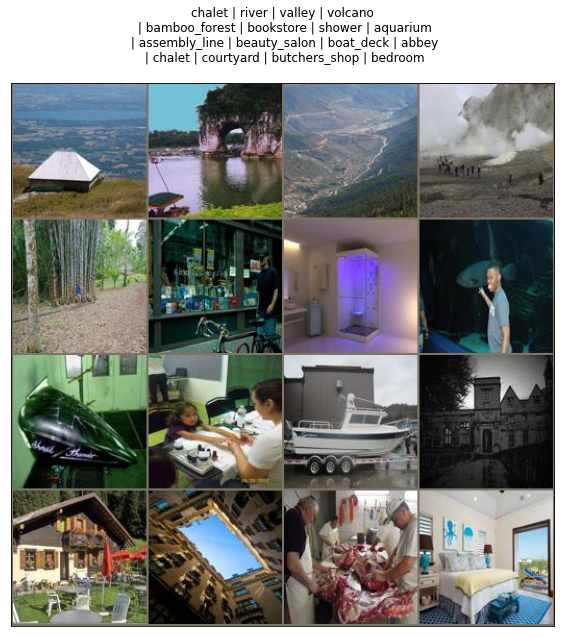

In [6]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [7]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [50]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers to get the features using the CNN.
    (That is, before the Average pooling layer in the two pictures above). 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential, please refer to PyTorch documents.
    '''
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    steps = []
    last = 3
    for i in cfg:
          if i != 'M':
            steps.append(nn.Conv2d(last, i, (3,3), (1,1), (1,1)))
            last = i
            if batch_norm == True:
              steps.append(nn.BatchNorm2d(i, 1e-05, 0.1, True, True))
          else:
            steps.append(nn.MaxPool2d(2, 2, 0, 1, False))
          steps.append(nn.ReLU(True))
    features = torch.nn.Sequential(*steps)
        
    '''
    if batch_norm == False:
      features = torch.nn.Sequential(
        nn.Conv2d(3, 64, (3,3), (1,1), (1,1)),
        nn.ReLU(True),
        nn.MaxPool2d(2, 2, 0, 1, False),
        nn.Conv2d(64, 128, (3,3), (1,1), (1,1)),
        nn.ReLU(True),
        nn.MaxPool2d(2, 2, 0, 1, False),
        nn.Conv2d(128, 128, (3,3), (1,1), (1,1)),
        nn.ReLU(True),
        nn.Conv2d(128, 128, (3,3), (1,1), (1,1)),
        nn.ReLU(True),
        nn.MaxPool2d(2, 2, 0, 1, False)
      )
    else:
      features = torch.nn.Sequential(
            nn.Conv2d(3, 64, (3,3), (1,1), (1,1)),
            nn.BatchNorm2d(64, 1e-05, 0.1, True, True),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2, 0, 1, False),
            nn.Conv2d(64, 128, (3,3), (1,1), (1,1)),
            nn.BatchNorm2d(128, 1e-05, 0.1, True, True),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2, 0, 1, False),
            nn.Conv2d(128, 128, (3,3), (1,1), (1,1)),
            nn.BatchNorm2d(128, 1e-05, 0.1, True, True),
            nn.ReLU(True),
            nn.Conv2d(128, 128, (3,3), (1,1), (1,1)),
            nn.BatchNorm2d(128, 1e-05, 0.1, True, True),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2, 0, 1, False)
        )
'''
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

         
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        # Construct the final FC layers using nn.Sequential.
        # NOTE: The avgpool layer has already been defined by us above.
        self.classifier = nn.Sequential(
            nn.Linear(3200, 512, True),
            nn.ReLU(True),
            nn.Dropout(0.3, False),
            nn.Linear(512, 256, True),
            nn.ReLU(True),
            nn.Dropout(0.3, False),
            nn.Linear(256, 100, True)
        )
        
        
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [51]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with the one given in the instruction above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)


## Step 3: Build training/validation loops

You will write a function for training and validating the network. 

In [10]:
def make_optimizer(model):
    '''
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    '''
    
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #
    # Create a SGD optimizer with a learning rate 1e-2, momentum = 0.9
    # HINT:
    # We have imported torch.optim as optim for you
    # Checkout optim.SGD() and initialize with appropriate parameters
    optimizer = optim.SGD(model.parameters(), 1e-2, 0.9)


    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return optimizer

def get_loss():
    '''
    Returns:
        criterion: pytorch loss. 
    '''

    
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #
    # Create an instance of the cross entropy loss function 
    # The code should be a one-liner.
    # Hint: 
    # See criterion in pytorch_tutorial discussion and find the function in nn
    # for cross entropy loss function. 
    criterion = nn.CrossEntropyLoss()
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return criterion

In [18]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 
                # ============== YOUR CODE HERE ============== #
                # Please read all the inputs carefully!
                # For "train" phase: 
                # (i)   Compute the outputs using model
                #       Also, use outputs to calculate predicted class by model,
                #       Store the predicted class in variable 'preds'
                #       (Think argmax of outputs across a dimension)
                #       torch.max() might help!
                # (ii)  Calculate the loss using criterion. Store it as 'loss' 
                # (iii) Update the model parameters

                # Don't forget to zero the gradients for each iteration!
                
                # For "val" phase, same as train but without backprop 
                # Compute the outputs (Same as "train", calculate 'preds' also), 
                # Calculate the loss, store it as 'loss'
                if (phase == 'train'):
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  _, preds = torch.max(outputs.data, 1)

                  loss = criterion(outputs, labels)
                  loss.backward()
                  optimizer.step()

                  make_optimizer(model)
                  
                else:
                  outputs = model(inputs)
                  _, preds = torch.max(outputs.data, 1)

                  loss = criterion(outputs, labels)
                  

                # ============== END OF CODE ================= # 
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # ================================ IMPORTANT ===============================================
                # Lossing connection to colab will lead to loss of trained weights.
                # You can download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to train the neural networks again.
                # ==========================================================================================
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 4. Train MiniVGG and MiniVGG-BN

In [19]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [20]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.5355 Acc: 0.0175


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 4.3248 Acc: 0.0318
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.1290 Acc: 0.0580


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.8670 Acc: 0.0934
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.8015 Acc: 0.1077


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.6369 Acc: 0.1383
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.5744 Acc: 0.1436


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.4488 Acc: 0.1592
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.3939 Acc: 0.1733


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2554 Acc: 0.1972
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.2445 Acc: 0.2003


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1541 Acc: 0.2202
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1127 Acc: 0.2244


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0339 Acc: 0.2382
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0090 Acc: 0.2452


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9755 Acc: 0.2554
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9017 Acc: 0.2672


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8963 Acc: 0.2693
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8060 Acc: 0.2850


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8472 Acc: 0.2847
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7215 Acc: 0.3037


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7689 Acc: 0.2954
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6286 Acc: 0.3224


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7262 Acc: 0.3074
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5409 Acc: 0.3389


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7294 Acc: 0.3128
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4550 Acc: 0.3575


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7038 Acc: 0.3157
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3801 Acc: 0.3727


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6995 Acc: 0.3220
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2915 Acc: 0.3897


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7440 Acc: 0.3149
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2143 Acc: 0.4052


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6887 Acc: 0.3243
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1365 Acc: 0.4211


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7218 Acc: 0.3276
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0624 Acc: 0.4370


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7321 Acc: 0.3257
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9852 Acc: 0.4517


100%|██████████| 79/79 [00:06<00:00, 11.35it/s]

val Loss: 2.7704 Acc: 0.3198
Best val Acc: 0.327600


In [21]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.2104 Acc: 0.0474


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.8251 Acc: 0.0970
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.5967 Acc: 0.1327


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.3411 Acc: 0.1704
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.3309 Acc: 0.1793


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2728 Acc: 0.1939
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1676 Acc: 0.2077


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1313 Acc: 0.2164
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0432 Acc: 0.2337


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0006 Acc: 0.2408
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9428 Acc: 0.2529


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8985 Acc: 0.2641
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8517 Acc: 0.2713


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8753 Acc: 0.2674
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7693 Acc: 0.2890


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8925 Acc: 0.2719
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6980 Acc: 0.3035


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0010 Acc: 0.2634
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6245 Acc: 0.3190


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6684 Acc: 0.3130
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5622 Acc: 0.3324


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6769 Acc: 0.3115
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4923 Acc: 0.3459


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5977 Acc: 0.3251
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4364 Acc: 0.3586


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6232 Acc: 0.3288
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3719 Acc: 0.3726


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6556 Acc: 0.3174
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3174 Acc: 0.3832


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.4986 Acc: 0.3539
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2538 Acc: 0.3981


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5001 Acc: 0.3566
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1988 Acc: 0.4113


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5248 Acc: 0.3535
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1452 Acc: 0.4220


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5569 Acc: 0.3479
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0889 Acc: 0.4322


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5055 Acc: 0.3591
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0292 Acc: 0.4471


100%|██████████| 79/79 [00:06<00:00, 11.54it/s]

val Loss: 2.4919 Acc: 0.3657
Best val Acc: 0.365700


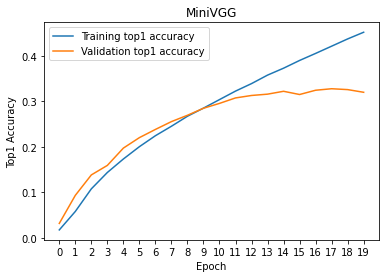

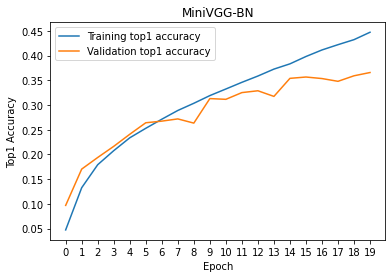

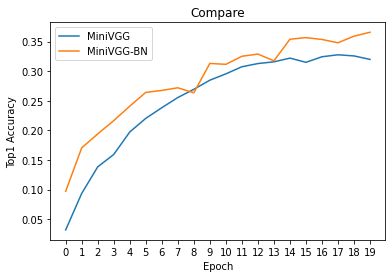

In [22]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)

# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, tr_his)
plt.plot(x, val_his)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, val_his)
plt.plot(x, val_his_BN)
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

###__Summarize the effect of batch normalization:__

Please write a few sentences here to summarize the effect of batch nomalization.

## Step 5. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [23]:
def accuracy(output, target, topk=(1,)):
    '''
    Computes the accuracy over the k top predictions for the specified values of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    '''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [25]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
# uncomment these two lines to load pretrained weights
# vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
# vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 36.2%, Top-5 accuracy 66.94%
Top-1 accuracy 32.93%, Top-5 accuracy 62.64%
